In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
# plt.rcParams.update({'font.size': 18})

In [2]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid
    
def lin_fit(x, a, b):
    return a + b*x

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def binning_data(array1,array2,delt):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
    plt.figure(figsize=(10,6))
    plt.scatter(levels_centres,binned_data)


def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return param

def remove_nan(array1,array2):
    selector = ~np.isnan(array1)
    array1_fil = array1[selector]
    array2_fil = array2[selector]

    selector = ~np.isnan(array2_fil)
    array1_fil = array1_fil[selector]
    array2_fil = array2_fil[selector]
    return array1_fil,array2_fil

def binning_datav1(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    plt.figure(figsize=(12,8))
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,c='k')

def binning_datav2(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    # plt.figure(figsize=(10,6))
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,c='k')

def binning_datav3(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    level_bins = np.linspace(np.amin(levels_centres),np.amax(levels_centres),10)
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    levels_centres = np.array(levels_centres)
    param, PS_param_cov = curve_fit(lin_fit, levels_centres, binned_data,sigma=error_bar)
    PS_FitFunc = lin_fit(level_bins,param[0],param[1])
    return param,level_bins,PS_FitFunc


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u

# Optional settings for the plots. Comment out if needed.
import seaborn as sb
sb.set_context('poster')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12., 9.6)

In [4]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
FITS2 = '../FITS_file/DR21_NH2_Repr.fits'
FITS3 = '../FITS_file/DR21_Tdust_Repr.fits'
FITS4 = '../FITS_file/DR21_IRAC4_Repr.fits'
FITS5 = '../FITS_file/DR21_Her250_Repr.fits'
hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
# print(hdul.info())



MapStokesI = hdul[0]
MapStokesIError = hdul[1]

MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapHer250 = hdul5[0]



MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapStokesI = MapStokesI.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapHer250 = MapHer250.copy()



######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan



############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############ removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)

BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)



In [5]:
from fil_finder import FilFinder2D
from astropy.io import fits

arr = MapStokesI.data
hdr = MapStokesI.header
fil = FilFinder2D(arr,header=hdr,beamwidth=18.4* u.arcsec,distance=1700*u.pc,)

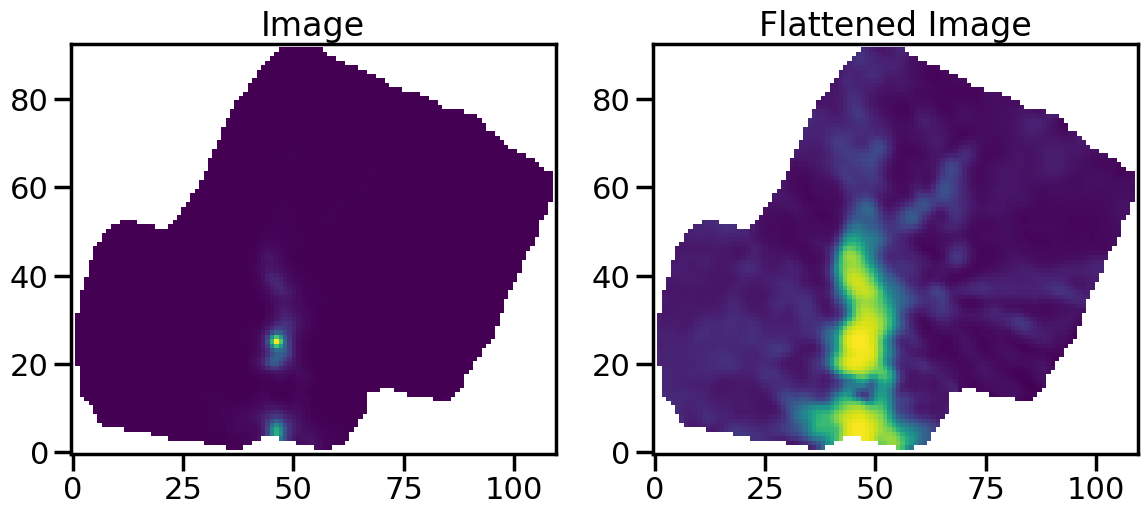

In [6]:
fil.preprocess_image(flatten_percent=92)
plt.subplot(121)
plt.imshow(fil.image.value, origin='lower')
plt.title("Image")
plt.subplot(122)
plt.imshow(fil.flat_img.value, origin='lower')
plt.title("Flattened Image")
plt.tight_layout()
plt.show()

c:\Users\DELL\anaconda3\envs\polarimetry\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
c:\Users\DELL\anaconda3\envs\polarimetry\lib\site-packages\fil_finder\filament.py:1013: UserWarning: Ignoring adding the width to the length because the fail flag was raised for the fit.
  warnings.warn("Ignoring adding the width to the length because"


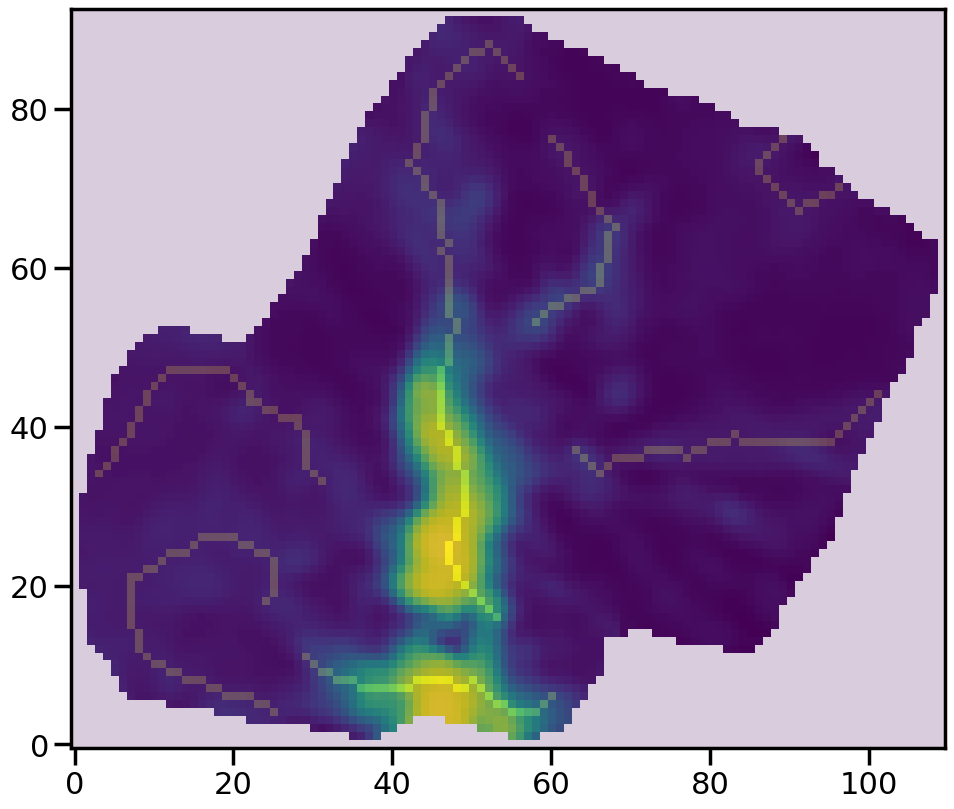

In [7]:
fil.preprocess_image(flatten_percent=92) # doctest: +SKIP
fil.create_mask(verbose=False,  border_masking=False, glob_thresh=0.5)
fil.medskel(verbose=False) # doctest: +SKIP
fil.analyze_skeletons(verbose=False,branch_thresh=4000* u.pix, prune_criteria='length') # doctest: +SKIP
fil.exec_rht(verbose=False) # doctest: +SKIP
fil.find_widths(verbose=False) # doctest: +SKIP
plt.imshow(fil.flat_img.value, origin='lower')
plt.imshow(fil.skeleton, origin='lower',alpha=0.2)
# plt.contour(fil.skeleton_longpath, colors='r')
plt.show()
# fil.save_fits() # doctest: +SKIP
# fil.save_stamp_fits() # doctest: +SKIP

In [8]:
fil.filaments

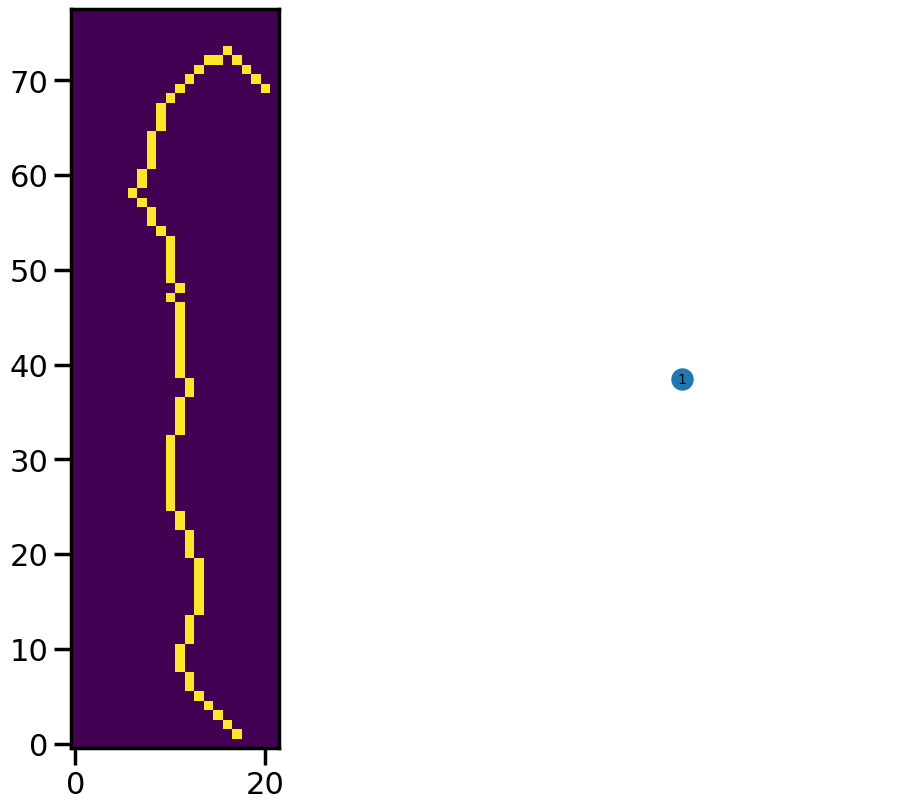

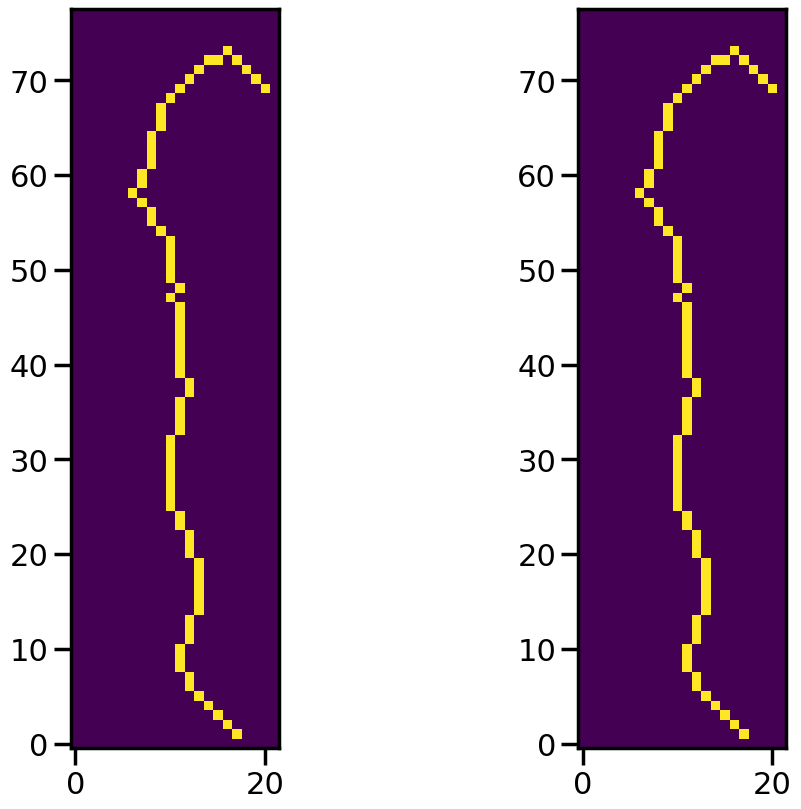

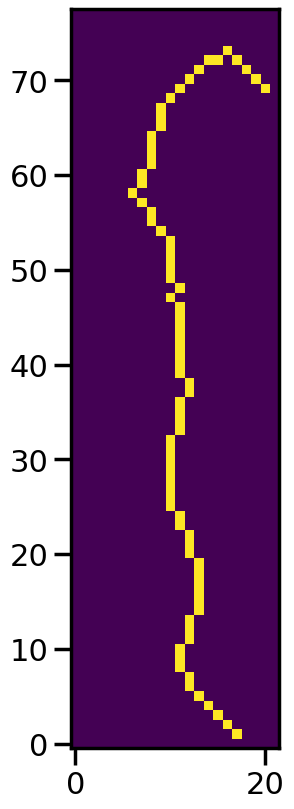

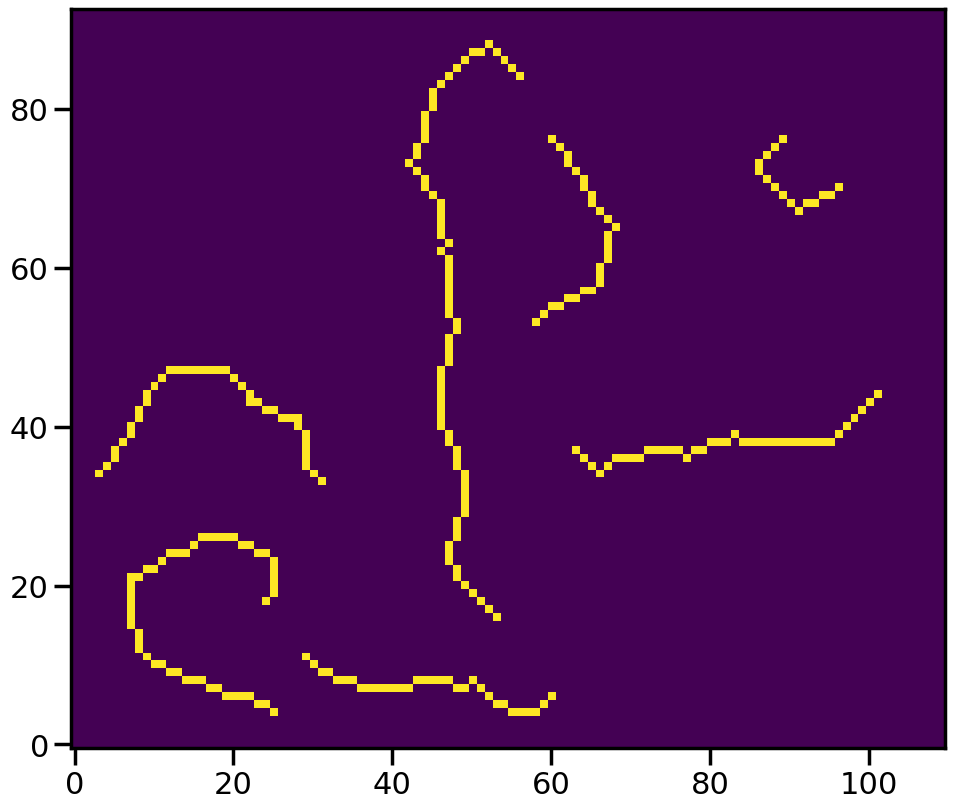

In [9]:
fil1 = fil.filaments[2]
fil1.skeleton_analysis(fil.image, verbose=True, branch_thresh=5 * u.pix, prune_criteria='length')
plt.imshow(fil.skeleton, origin='lower')
plt.show()